# CSI Fingerprinting

## Imports

In [1]:
!mkdir results/fingerprinting

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '4'

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

mkdir: cannot create directory ‘results/fingerprinting’: File exists


## Load Dataset

In [2]:
# time domain CSI
start_tap = 27
stop_tap = 40

csi_time_domain_RAW = np.load("dataset/csi_time_domain_RAW.npy")[...,start_tap:stop_tap]
csi_time_domain_RAW_RECOVERED = np.load("dataset/csi_time_domain_RAW_RECOVERED.npy")[...,start_tap:stop_tap]

csi_time_domain_RAW_test = np.load("dataset/csi_time_domain_RAW_test.npy")[...,start_tap:stop_tap]
csi_time_domain_RAW_RECOVERED_test = np.load("dataset/csi_time_domain_RAW_RECOVERED_test.npy")[...,start_tap:stop_tap]
csi_time_domain_OBFUSCATED_test = np.load("dataset/csi_time_domain_OBFUSCATED_test.npy")[...,start_tap:stop_tap]
csi_time_domain_RECOVERED_test = np.load("dataset/csi_time_domain_RECOVERED_test.npy")[...,start_tap:stop_tap]

# ground truth positions
groundtruth_positions = np.load("dataset/groundtruth_positions.npy")
groundtruth_positions_test = np.load("dataset/groundtruth_positions_test.npy")

groundtruth_positions = groundtruth_positions[:,:2]
groundtruth_positions_test = groundtruth_positions_test[:,:2]

## Visualizing the Dataset

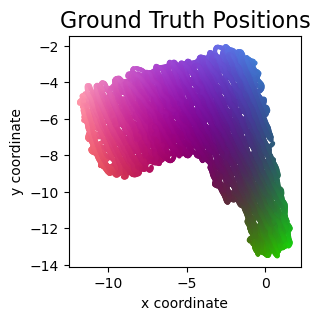

In [3]:
def plot_colorized(positions, groundtruth_positions, title = None, show = True, alpha = 1.0):
    # Generate RGB colors for datapoints
    center_point = np.zeros(2, dtype = np.float32)
    center_point[0] = 0.5 * (np.min(groundtruth_positions[:, 0], axis = 0) + np.max(groundtruth_positions[:, 0], axis = 0))
    center_point[1] = 0.5 * (np.min(groundtruth_positions[:, 1], axis = 0) + np.max(groundtruth_positions[:, 1], axis = 0))
    NormalizeData = lambda in_data : (in_data - np.min(in_data)) / (np.max(in_data) - np.min(in_data))
    rgb_values = np.zeros((groundtruth_positions.shape[0], 3))
    rgb_values[:, 0] = 1 - 0.9 * NormalizeData(groundtruth_positions[:, 0])
    rgb_values[:, 1] = 0.8 * NormalizeData(np.square(np.linalg.norm(groundtruth_positions[:,:2] - center_point, axis=1)))
    rgb_values[:, 2] = 0.9 * NormalizeData(groundtruth_positions[:, 1])

    # Plot datapoints
    plt.figure(figsize=(3, 3))
    if title is not None:
        plt.title(title, fontsize=16)
    plt.scatter(positions[:, 0], positions[:, 1], c = rgb_values, alpha = alpha, s = 10, linewidths = 0)
    plt.xlabel("x coordinate")
    plt.ylabel("y coordinate")
    if show:
        plt.show()

plot_colorized(groundtruth_positions[:,:2], groundtruth_positions[:,:2], title="Ground Truth Positions")

## Supervised Localization: CSI-Fingerprinting

## Scenario 1: Training on Original (Raw) CSI

In [4]:
# Feature Engineering Layer
class FeatureEngineeringLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(FeatureEngineeringLayer, self).__init__(dtype = tf.complex64)

    def call(self, csi):
        # Compute sample autocorrelations for any combination of two antennas in the whole system
        # for the same datapoint and time tap.
        # csi has shape (batchsize, array, antenna row, antenna column, tap)
        sample_autocorrelations = tf.einsum("dbrmt,dbsnt->dtbrmsn", csi, tf.math.conj(csi))
        return tf.stack([tf.math.real(sample_autocorrelations), tf.math.imag(sample_autocorrelations)], axis = -1)

### Defining the Neural Network

In [5]:
# Define the fingerprinting model
array_count = np.shape(csi_time_domain_RAW)[1]
rows_per_array_count = np.shape(csi_time_domain_RAW)[2]
antennas_per_row_count = np.shape(csi_time_domain_RAW)[3]
tap_count = np.shape(csi_time_domain_RAW)[4]

fingerprinting_model_input = tf.keras.Input(shape = (array_count, rows_per_array_count, antennas_per_row_count, tap_count), name="input", dtype = tf.complex64)
fingerprinting_model_output = FeatureEngineeringLayer()(fingerprinting_model_input)
fingerprinting_model_output = tf.keras.layers.Flatten()(fingerprinting_model_output)
fingerprinting_model_output = tf.keras.layers.Dense(1024, activation = "relu")(fingerprinting_model_output)
fingerprinting_model_output = tf.keras.layers.BatchNormalization()(fingerprinting_model_output)
fingerprinting_model_output = tf.keras.layers.Dense(512, activation = "relu")(fingerprinting_model_output)
fingerprinting_model_output = tf.keras.layers.BatchNormalization()(fingerprinting_model_output)
fingerprinting_model_output = tf.keras.layers.Dense(256, activation = "relu")(fingerprinting_model_output)
fingerprinting_model_output = tf.keras.layers.BatchNormalization()(fingerprinting_model_output)
fingerprinting_model_output = tf.keras.layers.Dense(128, activation = "relu")(fingerprinting_model_output)
fingerprinting_model_output = tf.keras.layers.BatchNormalization()(fingerprinting_model_output)
fingerprinting_model_output = tf.keras.layers.Dense(64, activation = "relu")(fingerprinting_model_output)
fingerprinting_model_output = tf.keras.layers.BatchNormalization()(fingerprinting_model_output)
fingerprinting_model_output = tf.keras.layers.Dense(2, activation = "linear")(fingerprinting_model_output)

fingerprinting_model = tf.keras.Model(inputs=fingerprinting_model_input, outputs=fingerprinting_model_output, name = "FingerprintingFunction")

### Training

In [6]:
# Compile the model
fingerprinting_model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError())

# learning rate reduction callback
# This will reduce the learning rate by a factor of 10 if the loss does not improve for 3 epochs
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3)

# Train the model on RAW CSI
fingerprinting_model.fit(csi_time_domain_RAW, groundtruth_positions, epochs=40, callbacks=[reduce_lr])

Epoch 1/40
652/652 [==============================] - 9s 8ms/step - loss: 7.0935 - lr: 0.0010
Epoch 2/40
652/652 [==============================] - 5s 8ms/step - loss: 0.4199 - lr: 0.0010
Epoch 3/40
652/652 [==============================] - 5s 8ms/step - loss: 0.3663 - lr: 0.0010
Epoch 4/40
652/652 [==============================] - 5s 8ms/step - loss: 0.3806 - lr: 0.0010
Epoch 5/40
652/652 [==============================] - 5s 8ms/step - loss: 0.3523 - lr: 0.0010
Epoch 6/40
652/652 [==============================] - 5s 8ms/step - loss: 0.3594 - lr: 0.0010
Epoch 7/40
652/652 [==============================] - 5s 8ms/step - loss: 0.3308 - lr: 0.0010
Epoch 8/40
652/652 [==============================] - 5s 8ms/step - loss: 0.3170 - lr: 0.0010
Epoch 9/40
652/652 [==============================] - 5s 8ms/step - loss: 0.3676 - lr: 0.0010
Epoch 10/40
652/652 [==============================] - 5s 8ms/step - loss: 0.3422 - lr: 0.0010
Epoch 11/40
652/652 [==============================] - 5s 8

## Evaluation on Original (Raw) CSI (Test Set)

652/652 [==============================] - 1s 2ms/step


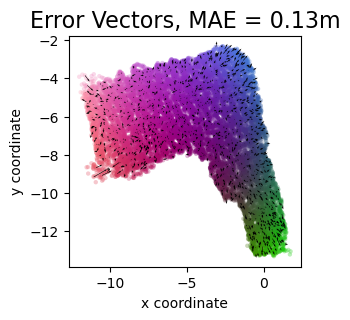

In [7]:
# Inference on RAW CSI
fingerprinting_positions_RAW_test = fingerprinting_model.predict(csi_time_domain_RAW_test)

# Calculate errors and plot results for RAW CSI
errorvectors = groundtruth_positions_test - fingerprinting_positions_RAW_test
errors_RAW_test = np.sqrt(errorvectors[:,0]**2 + errorvectors[:,1]**2)
mae = np.round(np.mean(errors_RAW_test), 2)

nth_errorvector = 15
plot_colorized(fingerprinting_positions_RAW_test, groundtruth_positions_test, title = "Error Vectors, MAE = " + str(mae) + "m", show = False, alpha = 0.3)
plt.quiver(fingerprinting_positions_RAW_test[::nth_errorvector, 0], fingerprinting_positions_RAW_test[::nth_errorvector, 1], errorvectors[::nth_errorvector, 0], errorvectors[::nth_errorvector, 1], color = "black", angles = "xy", scale_units = "xy", scale = 1)
plt.savefig("results/fingerprinting/fingerprinting_errors_RAW_test",bbox_inches='tight',dpi=300)
plt.show()

## Evaluation on Obfuscated CSI (Test Set)

652/652 [==============================] - 1s 2ms/step


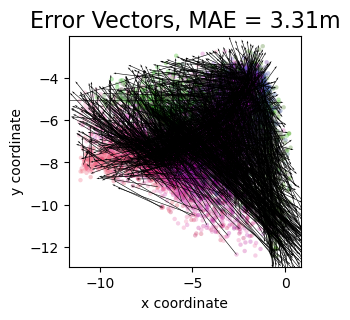

In [8]:
# Inference on OBFUSCATED CSI
fingerprinting_positions_OBFUSCATED_test = fingerprinting_model.predict(csi_time_domain_OBFUSCATED_test)

# Calculate errors and plot results for OBFUSCATED CSI
errorvectors = groundtruth_positions_test - fingerprinting_positions_OBFUSCATED_test
errors_OBFUSCATED_test = np.sqrt(errorvectors[:,0]**2 + errorvectors[:,1]**2)
mae = np.round(np.mean(errors_OBFUSCATED_test), 2)

nth_errorvector = 15
plot_colorized(fingerprinting_positions_OBFUSCATED_test, groundtruth_positions_test, title = "Error Vectors, MAE = " + str(mae) + "m", show = False, alpha = 0.3)
plt.quiver(fingerprinting_positions_OBFUSCATED_test[::nth_errorvector, 0], fingerprinting_positions_OBFUSCATED_test[::nth_errorvector, 1], errorvectors[::nth_errorvector, 0], errorvectors[::nth_errorvector, 1], color = "black", angles = "xy", scale_units = "xy", scale = 1)
plt.savefig("results/fingerprinting/fingerprinting_errors_OBFUSCATED_test",bbox_inches='tight',dpi=300)
plt.show()

## Scenario 2: Training on Recovered Original (Raw) CSI

In [9]:
# Feature Engineering Layer
class FeatureEngineeringLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(FeatureEngineeringLayer, self).__init__(dtype = tf.complex64)

    def call(self, csi):
        # Compute sample autocorrelations for any combination of two antennas in the whole system
        # for the same datapoint and time tap.
        # csi has shape (batchsize, array, antenna row, antenna column, tap)
        sample_autocorrelations = tf.einsum("dbrmt,dbsnt->dtbrmsn", csi, tf.math.conj(csi))
        return tf.stack([tf.math.real(sample_autocorrelations), tf.math.imag(sample_autocorrelations)], axis = -1)

In [10]:
# Define the fingerprinting model
array_count = np.shape(csi_time_domain_RAW_RECOVERED)[1]
rows_per_array_count = np.shape(csi_time_domain_RAW_RECOVERED)[2]
antennas_per_row_count = np.shape(csi_time_domain_RAW_RECOVERED)[3]
tap_count = np.shape(csi_time_domain_RAW_RECOVERED)[4]

fingerprinting_model_input = tf.keras.Input(shape = (array_count, rows_per_array_count, antennas_per_row_count, tap_count), name="input", dtype = tf.complex64)
fingerprinting_model_output = FeatureEngineeringLayer()(fingerprinting_model_input)
fingerprinting_model_output = tf.keras.layers.Flatten()(fingerprinting_model_output)
fingerprinting_model_output = tf.keras.layers.Dense(1024, activation = "relu")(fingerprinting_model_output)
fingerprinting_model_output = tf.keras.layers.BatchNormalization()(fingerprinting_model_output)
fingerprinting_model_output = tf.keras.layers.Dense(512, activation = "relu")(fingerprinting_model_output)
fingerprinting_model_output = tf.keras.layers.BatchNormalization()(fingerprinting_model_output)
fingerprinting_model_output = tf.keras.layers.Dense(256, activation = "relu")(fingerprinting_model_output)
fingerprinting_model_output = tf.keras.layers.BatchNormalization()(fingerprinting_model_output)
fingerprinting_model_output = tf.keras.layers.Dense(128, activation = "relu")(fingerprinting_model_output)
fingerprinting_model_output = tf.keras.layers.BatchNormalization()(fingerprinting_model_output)
fingerprinting_model_output = tf.keras.layers.Dense(64, activation = "relu")(fingerprinting_model_output)
fingerprinting_model_output = tf.keras.layers.BatchNormalization()(fingerprinting_model_output)
fingerprinting_model_output = tf.keras.layers.Dense(2, activation = "linear")(fingerprinting_model_output)

fingerprinting_model = tf.keras.Model(inputs=fingerprinting_model_input, outputs=fingerprinting_model_output, name = "FingerprintingFunction")

In [11]:
# Compile the model
fingerprinting_model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError())

# learning rate reduction callback
# This will reduce the learning rate by a factor of 10 if the loss does not improve for 3 epochs
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3)

# Train the model on RAW RECOVERED CSI
fingerprinting_model.fit(csi_time_domain_RAW_RECOVERED, groundtruth_positions, epochs=40, callbacks=[reduce_lr])

Epoch 1/40
652/652 [==============================] - 9s 8ms/step - loss: 6.7766 - lr: 0.0010
Epoch 2/40
652/652 [==============================] - 5s 8ms/step - loss: 0.4150 - lr: 0.0010
Epoch 3/40
652/652 [==============================] - 5s 8ms/step - loss: 0.3640 - lr: 0.0010
Epoch 4/40
652/652 [==============================] - 5s 8ms/step - loss: 0.3998 - lr: 0.0010
Epoch 5/40
652/652 [==============================] - 5s 8ms/step - loss: 0.3425 - lr: 0.0010
Epoch 6/40
652/652 [==============================] - 5s 8ms/step - loss: 0.3412 - lr: 0.0010
Epoch 7/40
652/652 [==============================] - 5s 8ms/step - loss: 0.3405 - lr: 0.0010
Epoch 8/40
652/652 [==============================] - 5s 8ms/step - loss: 0.3757 - lr: 0.0010
Epoch 9/40
652/652 [==============================] - 5s 8ms/step - loss: 0.3324 - lr: 0.0010
Epoch 10/40
652/652 [==============================] - 5s 8ms/step - loss: 0.3301 - lr: 0.0010
Epoch 11/40
652/652 [==============================] - 5s 8

## Evaluation on Recovered Original (Raw) CSI (Test Set)

652/652 [==============================] - 2s 2ms/step


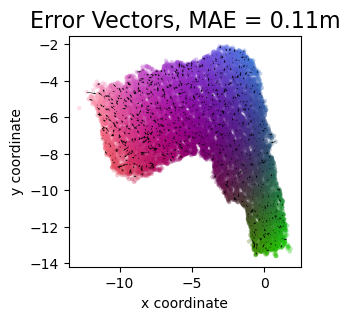

In [12]:
# Inference on RAW RECOVERED CSI
fingerprinting_positions_RAW_RECOVERED_test = fingerprinting_model.predict(csi_time_domain_RAW_RECOVERED_test)

# Calculate errors and plot results for RAW RECOVERED CSI
errorvectors = groundtruth_positions_test - fingerprinting_positions_RAW_RECOVERED_test
errors_RAW_RECOVERED_test = np.sqrt(errorvectors[:,0]**2 + errorvectors[:,1]**2)
mae = np.round(np.mean(errors_RAW_RECOVERED_test), 2)

nth_errorvector = 15
plot_colorized(fingerprinting_positions_RAW_RECOVERED_test, groundtruth_positions_test, title = "Error Vectors, MAE = " + str(mae) + "m", show = False, alpha = 0.3)
plt.quiver(fingerprinting_positions_RAW_RECOVERED_test[::nth_errorvector, 0], fingerprinting_positions_RAW_RECOVERED_test[::nth_errorvector, 1], errorvectors[::nth_errorvector, 0], errorvectors[::nth_errorvector, 1], color = "black", angles = "xy", scale_units = "xy", scale = 1)
plt.savefig("results/fingerprinting/fingerprinting_errors_RAW_RECOVERED_test",bbox_inches='tight',dpi=300)
plt.show()

## Evaluation on Recovered Obfuscated CSI (Test Set)

652/652 [==============================] - 1s 2ms/step


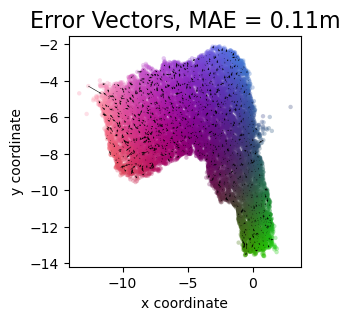

In [13]:
# Inference on RECOVERED CSI
fingerprinting_positions_RECOVERED_test = fingerprinting_model.predict(csi_time_domain_RECOVERED_test)

# Calculate errors and plot results for RECOVERED CSI
errorvectors = groundtruth_positions_test - fingerprinting_positions_RECOVERED_test
errors_RECOVERED_test = np.sqrt(errorvectors[:,0]**2 + errorvectors[:,1]**2)
mae = np.round(np.mean(errors_RECOVERED_test), 2)

nth_errorvector = 15
plot_colorized(fingerprinting_positions_RECOVERED_test, groundtruth_positions_test, title = "Error Vectors, MAE = " + str(mae) + "m", show = False, alpha = 0.3)
plt.quiver(fingerprinting_positions_RECOVERED_test[::nth_errorvector, 0], fingerprinting_positions_RECOVERED_test[::nth_errorvector, 1], errorvectors[::nth_errorvector, 0], errorvectors[::nth_errorvector, 1], color = "black", angles = "xy", scale_units = "xy", scale = 1)
plt.savefig("results/fingerprinting/fingerprinting_errors_RECOVERED_test",bbox_inches='tight',dpi=300)

plt.show()